# 2024 Fall CS180 Project 3

In [1]:
''' Here are all the libraries used in this project. '''
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import skimage.io as skio
import skimage as sk
import scipy.interpolate
import cv2
from scipy.ndimage import distance_transform_edt
from skimage.feature import corner_harris, peak_local_max

''' Set the random seed to ensure reproducibility. '''
np.random.seed(42)

''' Here are some supportive functions to process the images. '''
# Save the normalized image.
def save_normalized_image(image, imname):
    im_normalized = (image - image.min()) / (image.max() - image.min())
    im_uint8 = (im_normalized * 255).astype(np.uint8)
    fname = f'./output/{imname}.jpg'
    skio.imsave(fname, im_uint8)

## Recover Homographies

&emsp;&emsp;Before warping the images into alignment, we need to recover the parameters of the transformation between each pair of images. In our case, the transformation is a homography: $\mathbf{p^{\prime}} = \mathbf{Hp}$, where $\mathbf{H}$ is a $3 \times 3$ matrix with $8$ degrees of freedom (lower right corner is a scaling factor and can be set to $1$), that is
$$
\begin{bmatrix}
x^{\prime} \\
y^{\prime} \\
1 \\
\end{bmatrix} = \begin{bmatrix}
a & b & c \\
d & e & f \\
g & h & 1 \\
\end{bmatrix} \cdot \begin{bmatrix}
x \\
y \\
1 \\
\end{bmatrix}
$$
&emsp;&emsp;We could convert the equation above into th form of $\mathbf{Ah} = \mathbf{b}$, where $\mathbf{h} = \begin{bmatrix}
a, b, c, d, e, f, g, h \\
\end{bmatrix}^{\top}$. Then, for each pair of corresponding points, we have
$$
\begin{bmatrix}
x_{i} & y_{i} & 1 & 0 & 0 & 0 & -x_{i}x_{i}^{\prime} & -y_{i}x_{i}^{\prime} \\
0 & 0 & 0 & x_{i} & y_{i} & 1 & -x_{i}y_{i}^{\prime} & -y_{i}y_{i}^{\prime} \\
\end{bmatrix} \cdot \mathbf{h} = \begin{bmatrix}
x_{i}^{\prime} \\
y_{i}^{\prime} \\
\end{bmatrix}
$$
&emsp;&emsp;To solve this, at least 4 pairs of corresponding points should be chosen. However, with only four points, the homography recovery will be very unstable and prone to noise. Therefore more than 4 correspondences should be provided producing an overdetermined system which should be solved using least-squares. Then, we could solve this using least-squares,
$$
\mathbf{h} = \arg\min_{\mathbf{h}} \|\mathbf{Ah} - \mathbf{b}\|^{2} = (\mathbf{A}^{\top}\mathbf{A})^{-1}\mathbf{A}^{\top}\mathbf{b}
$$

In [2]:
def computeH(im1_pts, im2_pts):
    assert im1_pts.shape == im2_pts.shape, "Point sets must have the same shape"
    assert im1_pts.shape[0] >= 4 and im2_pts.shape[0] >= 4, "At least 4 points are required"
    A = []
    b = []
    rows = len(im1_pts)
    for i in range(rows):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A.append([x1, y1, 1, 0, 0, 0, -x1 * x2, -y1 * x2])
        A.append([0, 0, 0, x1, y1, 1, -x1 * y2, -y1 * y2])
        b.append([x2])
        b.append([y2])
    A = np.array(A)
    b = np.array(b)
    h = np.linalg.inv(np.dot(A.T, A)).dot(A.T).dot(b)
    H = np.array([[h[0, 0], h[1, 0], h[2, 0]],
                  [h[3, 0], h[4, 0], h[5, 0]],
                  [h[6, 0], h[7, 0], 1.0]])
    return H

## Warp the Images

&emsp;&emsp;To ensure that the warped image will not go beyond the canvas, I first add borders with 0, i.e. black borders, to them and modify the position of the corresponding points as well, which should be related to the size of border added. With the homography matrix $\mathbf{H}$, I could warp the source image to match the view direction of the target image.

&emsp;&emsp;I choose to perform inverse warping. I compute the corresponding coordinates of pixels in the source image of each pixels in the destination image, which could be calculated according to the homography matrix $\mathbf{H}$. Then, I use `scipy.interpolate.griddata` to perform interpolation.

&emsp;&emsp;You could find some examples from the following parts.

In [3]:
# Add borders in order to present the whole image.
def add_border(im, im_pts, ratio_h, ratio_w):
    h, w, _ = im.shape
    h_add, w_add = int(h * ratio_h), int(w * ratio_w)
    im_border = np.zeros((h + 2 * h_add, w + 2 * w_add, im.shape[2]), dtype=im.dtype)
    im_border[h_add : h_add + h, w_add : w_add + w] = im
    im_pts += np.array([w_add, h_add])
    return im_border, im_pts

# Process the inverse warping.
def warpImage(im, H):
    height, width, _ = im.shape

    y_out, x_out = np.indices((height, width))
    coords = np.stack([x_out.ravel(), y_out.ravel(), np.ones_like(x_out).ravel()])

    H_inv = np.linalg.inv(H)
    warped_coords = H_inv @ coords
    warped_coords /= warped_coords[2]
    warped_coords = warped_coords[:2].T

    im_warped = np.zeros_like(im)
    for i in range(3):
        im_warped[..., i] = scipy.interpolate.griddata(
            warped_coords, im[..., i].ravel(),
            (x_out, y_out), method='nearest', fill_value=0
        )

    return im_warped

## Image Rectification

&emsp;&emsp;Here are two examples of image rectification. 

H = [[ 1.02104636e+00 -4.51142741e-01  1.96971626e+02]
 [ 4.87894563e-01  1.06545020e+00 -1.33641670e+02]
 [ 2.91815991e-06  1.04978994e-04  1.00000000e+00]]


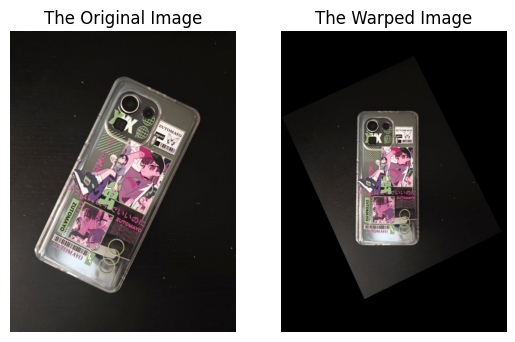

In [4]:
imname1 = './media/phone_lean.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname2 = './media/phone.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_points = np.loadtxt('./media/pts_phone_lean.txt')
im2_points = np.loadtxt('./media/pts_phone.txt')

im1_border, im1_pts = add_border(im1, im1_points, 0.2, 0.2)
im2_border, im2_pts = add_border(im2, im2_points, 0.2, 0.16)

H = computeH(im2_pts, im1_pts)
print(f'H = {H}')
im_warp = warpImage(im1_border, H)
save_normalized_image(im_warp, 'phone')

plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title('The Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_warp)
plt.title('The Warped Image')
plt.axis('off')
plt.show()

H = [[ 1.01596712e+00  2.02444332e-01 -1.24642062e+02]
 [-3.81013277e-02  8.31899238e-02  4.34852874e+02]
 [ 6.04747005e-04 -5.32424192e-04  1.00000000e+00]]


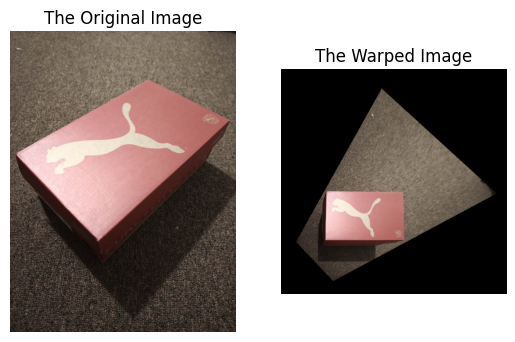

In [5]:
imname1 = './media/puma_lean.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname2 = './media/puma.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_points = np.loadtxt('./media/pts_puma_lean.txt')
im2_points = np.loadtxt('./media/pts_puma.txt')

im1_border, im1_pts = add_border(im1, im1_points, 0.4, 0.7)
im2_border, im2_pts = add_border(im2, im2_points, 0.7, 0.4)

H = computeH(im2_pts, im1_pts)
print(f'H = {H}')
im_warp = warpImage(im1_border, H)
save_normalized_image(im_warp, 'puma')

plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.title('The Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(im_warp)
plt.title('The Warped Image')
plt.axis('off')
plt.show()

## Blend the images into a mosaic

&emsp;&emsp;To blend the images into a mosaic, I choose the central image as a target for the other images to warp to. Once they are warpped, build alpha mask for them following the logic below:
$$
    \alpha = \text{logical}(\text{dtrans}1 > \text{dtrans}2)
$$
$$
    \alpha = \text{blurred}
$$
&emsp;&emsp;That is, set the part where transformed distance of image 1 is larger as $1$, and then blur the mask.

&emsp;&emsp;Then I could blend all image together with Laplacian stacks to make a mosaic. I also tried Laplacian pyramids as well, but the results of stack are better. I use alpha mask to blend images and the target image. To blend the bended images together, I just use the trivial mask that divide the image into left and right part since the target is set to center.

&emsp;&emsp;The results are shown below.

In [6]:
# Perform warping to align the source image to the target image.
def warping(im1, im2, im1_points, im2_points, ratio_h, ratio_w):
    im1_border, im1_pts = add_border(im1, im1_points, ratio_h, ratio_w)
    im2_border, im2_pts = add_border(im2, im2_points, ratio_h, ratio_w)

    H = computeH(im2_pts, im1_pts)
    return warpImage(im1_border, H), im2_border

# Compute the distance transform.
def distance(im):
    non_black_mask = np.any(im != [0, 0, 0], axis=-1).astype(np.float32)
    dist = distance_transform_edt(non_black_mask)
    max_dist = np.max(dist)
    dist = dist / max_dist
    dist = np.stack([dist, dist, dist], axis=-1)
    return dist

# Create the alpha mask.
def create_alpha_mask(im1, im2, kernel_size=(3,3), sigma=1):
    alpha = (distance(im1) > distance(im2)).astype(np.float32)
    return cv2.GaussianBlur(alpha, kernel_size, sigma)

# Generate a Gaussian stack.
def build_gaussian_stack(image, kernel_size, sigma, level):
    stack = []
    stack.append(image)
    for _ in range(level):
        stack.append(cv2.GaussianBlur(stack[-1], kernel_size, sigma))
    return stack

# Generate a Laplacian stack from the given Gaussian stack.
def build_laplacian_stack(gaussian_stack):
    laplacian_stack = []
    N = len(gaussian_stack) - 1
    for i in range(N):
        laplacian_stack.append(gaussian_stack[i] - gaussian_stack[i + 1])
    laplacian_stack.append(gaussian_stack[N])
    return laplacian_stack

# Blend two resource images together.
def blend(laplacian_stack1, laplacian_stack2, mask_gaussian_stack, shape):
    blend_stack = []
    for l1, l2, m in zip(laplacian_stack1, laplacian_stack2, mask_gaussian_stack):
        blend_stack.append(l1 * (1 - m) + l2 * m)
    blend_img = np.zeros(shape)
    reverse_stack = reversed(blend_stack)
    for laplacian in reverse_stack:
        blend_img = laplacian + blend_img
    return (blend_img - blend_img.min()) / (blend_img.max() - blend_img.min())

# Create a mosaic to the target image and plot & save it.
def mosaic(im1_warp, im2_warp, target_border, kernel_size, sigma, fname):
    level = 2
    mask1 = create_alpha_mask(target_border, im1_warp)
    mask_gaussian_stack1 = build_gaussian_stack(mask1, kernel_size, sigma, level)
    mask2 = create_alpha_mask(target_border, im2_warp)
    mask_gaussian_stack2 = build_gaussian_stack(mask2, kernel_size, sigma, level)    

    gaussian_stack1 = build_gaussian_stack(im1_warp, kernel_size, sigma, level)
    laplacian_stack1 = build_laplacian_stack(gaussian_stack1)
    gaussian_stack2 = build_gaussian_stack(im2_warp, kernel_size, sigma, level)
    laplacian_stack2 = build_laplacian_stack(gaussian_stack2)
    gaussian_stack_target = build_gaussian_stack(target_border, kernel_size, sigma, level)
    laplacian_stack_target = build_laplacian_stack(gaussian_stack_target)

    blend_img1 = blend(laplacian_stack1, laplacian_stack_target, mask_gaussian_stack1, im1_warp.shape)
    blend_img2 = blend(laplacian_stack2, laplacian_stack_target, mask_gaussian_stack2, im2_warp.shape)

    mask = np.zeros(blend_img1.shape)
    mask[:, mask.shape[1]//2:,:] = 1
    mask_gaussian_stack = build_gaussian_stack(mask, kernel_size, sigma, level)
    gaussian_stack1 = build_gaussian_stack(blend_img1, kernel_size, sigma, level)
    laplacian_stack1 = build_laplacian_stack(gaussian_stack1)
    gaussian_stack2 = build_gaussian_stack(blend_img2, kernel_size, sigma, level)
    laplacian_stack2 = build_laplacian_stack(gaussian_stack2)

    mosaic = blend(laplacian_stack1, laplacian_stack2, mask_gaussian_stack, blend_img1.shape)
    save_normalized_image(mosaic, fname)
    plt.imshow(mosaic)
    plt.axis('off')
    plt.show()

### Li Ka Shing Center

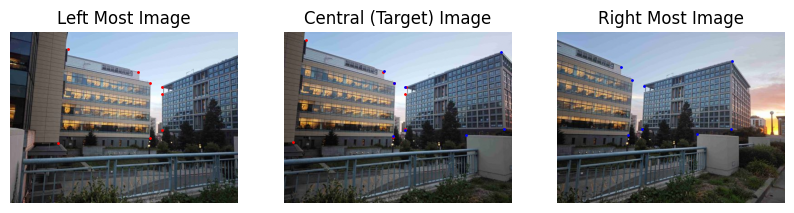

In [7]:
imname1 = './media/building_left.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname_target = './media/building_center.jpg'
im_target = skio.imread(imname_target)
im_target = sk.img_as_float(im_target)

imname2 = './media/building_right.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_points = np.loadtxt('./media/pts_building_left_lc.txt')
im2_points = np.loadtxt('./media/pts_building_right_cr.txt')
pts_target1 = np.loadtxt('./media/pts_building_center_lc.txt')
pts_target2 = np.loadtxt('./media/pts_building_center_cr.txt')

im1_x, im1_y = zip(*im1_points)
im2_x, im2_y = zip(*im2_points)
x_target1, y_target1 = zip(*pts_target1)
x_target2, y_target2 = zip(*pts_target2)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1)
axes[0].plot(im1_x, im1_y, 'ro', markersize=1)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(im_target)
axes[1].plot(x_target1, y_target1, 'ro', markersize=1)
axes[1].plot(x_target2, y_target2, 'bo', markersize=1)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2)
axes[2].plot(im2_x, im2_y, 'bo', markersize=1)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/pts_building.jpg', dpi=300, bbox_inches='tight')
plt.show()

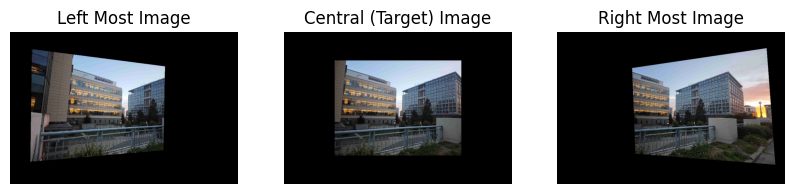

In [8]:
# Set the ratio of the borders.
ratio_h = 0.3
ratio_w = 0.4

im1_warp, target_border = warping(im1, im_target, im1_points, pts_target1, ratio_h, ratio_w)
im2_warp, _ = warping(im2, im_target, im2_points, pts_target2, ratio_h, ratio_w)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1_warp)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(target_border)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2_warp)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/warped_building.jpg', dpi=300, bbox_inches='tight')
plt.show()

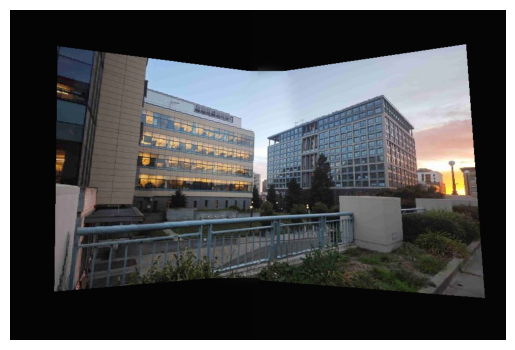

In [9]:
# Set the parameters to blend the images into a mosaic.
kernel_size = (25, 25)
sigma = 21

mosaic(im1_warp, im2_warp, target_border, kernel_size, sigma, 'mosaic_building')

### Street

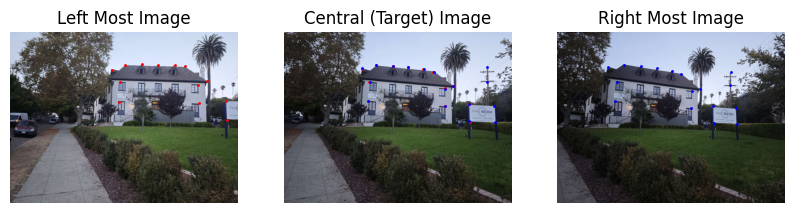

In [10]:
imname1 = './media/street_left.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname_target = './media/street_center.jpg'
im_target = skio.imread(imname_target)
im_target = sk.img_as_float(im_target)

imname2 = './media/street_right.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_points = np.loadtxt('./media/pts_street_left_lc.txt')
im2_points = np.loadtxt('./media/pts_street_right_cr.txt')
pts_target1 = np.loadtxt('./media/pts_street_center_lc.txt')
pts_target2 = np.loadtxt('./media/pts_street_center_cr.txt')

im1_x, im1_y = zip(*im1_points)
im2_x, im2_y = zip(*im2_points)
x_target1, y_target1 = zip(*pts_target1)
x_target2, y_target2 = zip(*pts_target2)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1)
axes[0].plot(im1_x, im1_y, 'ro', markersize=1)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(im_target)
axes[1].plot(x_target1, y_target1, 'ro', markersize=1)
axes[1].plot(x_target2, y_target2, 'bo', markersize=1)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2)
axes[2].plot(im2_x, im2_y, 'bo', markersize=1)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/pts_street.jpg', dpi=300, bbox_inches='tight')
plt.show()

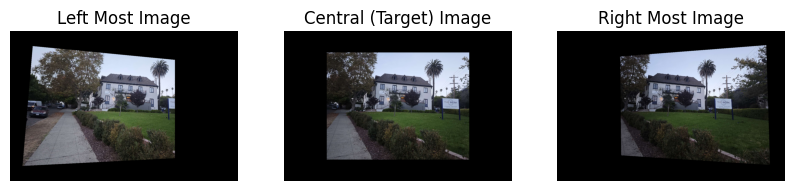

In [11]:
# Set the ratio of the borders.
ratio_h = 0.2
ratio_w = 0.3

im1_warp, target_border = warping(im1, im_target, im1_points, pts_target1, ratio_h, ratio_w)
im2_warp, _ = warping(im2, im_target, im2_points, pts_target2, ratio_h, ratio_w)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1_warp)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(target_border)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2_warp)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/warped_street.jpg', dpi=300, bbox_inches='tight')
plt.show()

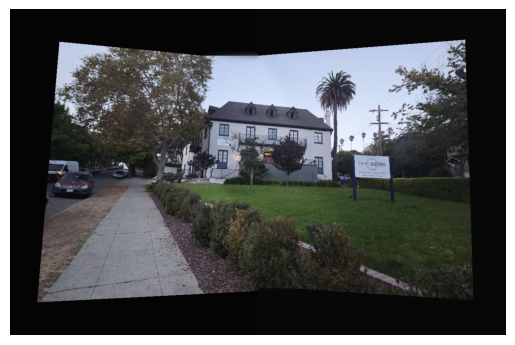

In [12]:
# Set the parameters to blend the images into a mosaic.
kernel_size = (25, 25)
sigma = 15

mosaic(im1_warp, im2_warp, target_border, kernel_size, sigma, 'mosaic_street')

### Valley Life Sciences Building

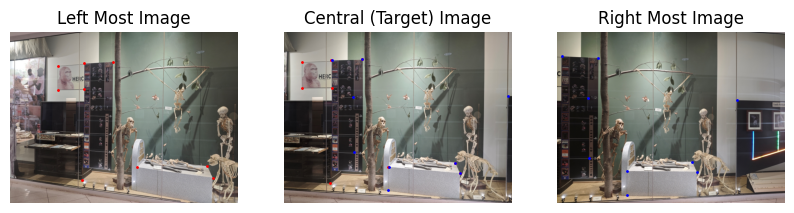

In [13]:
imname1 = './media/model_left.jpg'
im1 = skio.imread(imname1)
im1 = sk.img_as_float(im1)

imname_target = './media/model_center.jpg'
im_target = skio.imread(imname_target)
im_target = sk.img_as_float(im_target)

imname2 = './media/model_right.jpg'
im2 = skio.imread(imname2)
im2 = sk.img_as_float(im2)

im1_points = np.loadtxt('./media/pts_model_left_lc.txt')
im2_points = np.loadtxt('./media/pts_model_right_cr.txt')
pts_target1 = np.loadtxt('./media/pts_model_center_lc.txt')
pts_target2 = np.loadtxt('./media/pts_model_center_cr.txt')

im1_x, im1_y = zip(*im1_points)
im2_x, im2_y = zip(*im2_points)
x_target1, y_target1 = zip(*pts_target1)
x_target2, y_target2 = zip(*pts_target2)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1)
axes[0].plot(im1_x, im1_y, 'ro', markersize=1)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(im_target)
axes[1].plot(x_target1, y_target1, 'ro', markersize=1)
axes[1].plot(x_target2, y_target2, 'bo', markersize=1)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2)
axes[2].plot(im2_x, im2_y, 'bo', markersize=1)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/pts_model.jpg', dpi=300, bbox_inches='tight')
plt.show()

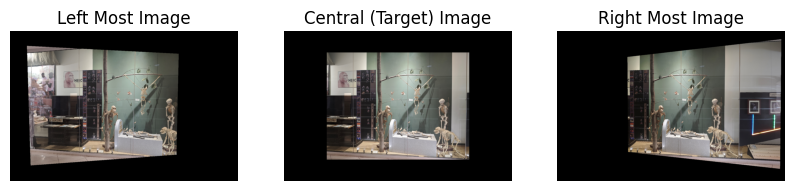

In [14]:
# Set the ratio of the borders.
ratio_h = 0.2
ratio_w = 0.3

im1_warp, target_border = warping(im1, im_target, im1_points, pts_target1, ratio_h, ratio_w)
im2_warp, _ = warping(im2, im_target, im2_points, pts_target2, ratio_h, ratio_w)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(im1_warp)
axes[0].set_title('Left Most Image')
axes[0].axis('off')
axes[1].imshow(target_border)
axes[1].set_title('Central (Target) Image')
axes[1].axis('off')
axes[2].imshow(im2_warp)
axes[2].set_title('Right Most Image')
axes[2].axis('off')
plt.savefig('./output/warped_model.jpg', dpi=300, bbox_inches='tight')
plt.show()

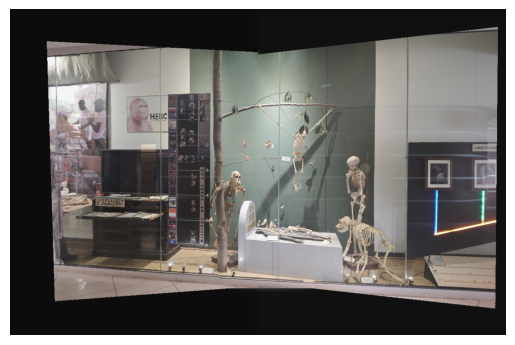

In [15]:
# Set the parameters to blend the images into a mosaic.
kernel_size = (25, 25)
sigma = 21

mosaic(im1_warp, im2_warp, target_border, kernel_size, sigma, 'mosaic_model')

## Feature Matching and Autostitching

&emsp;&emsp;I manually selected the corresponding points in the previous part. In this section, I developed a system to automatically identify matching points between a pair of images and then use these key points to warp and create a mosaic, similar to the previous method. This will consist of the following steps:
- Detecting corner features in an image.
- Extracting a Feature Descriptor for each feature point.
- Matching these feature descriptors between two images.
- Use a robust method (RANSAC) to compute a homography.
- Produce a mosaic.

### Start with Harris Interest Point Detector

&emsp;&emsp;For this part, I just used the sample code for implementing Harris corners detector. The `get_harris_corners` function is based on the Harris corner detection algorithm, which identifies corners by analyzing how the intensity values in a local neighborhood vary. The key idea is to detect points in an image where small shifts in any direction result in significant intensity changes.

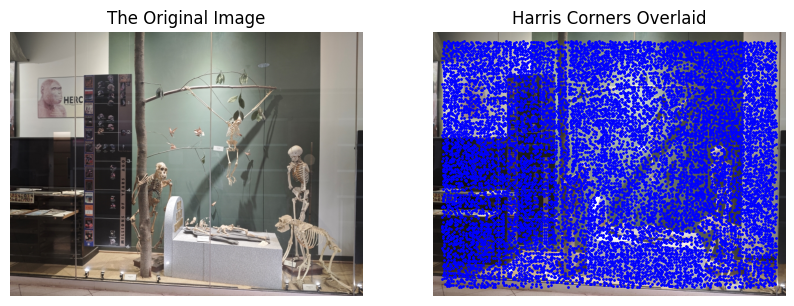

In [16]:
# The sample of Harris corner detector.
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """
    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords

imname = './media/model_center.jpg'
im_color = skio.imread(imname)
im_gray = rgb2gray(im_color)

h_response, h_corners = get_harris_corners(im_gray)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im_color)
axes[0].set_title('The Original Image')
axes[0].axis('off')
axes[1].imshow(im_color)
axes[1].scatter(h_corners[1], h_corners[0], color='b', marker='o', s=1)
axes[1].set_title('Harris Corners Overlaid')
axes[1].axis('off')
plt.savefig('./output/harris.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Implement Adaptive Non-Maximal Suppression

&emsp;&emsp;Once we have identified the Harris corners, we can apply Adaptive Non-Maximal Suppression to filter the potential keypoints, retaining only those that correspond to strong corners and are approximately evenly distributed across the image. The algorithm assigns every key point an $r$ score as follows, where the function $f$ corresponds to the Harris response:
$$
    r_{i} = \mathop{\min}\limits_{j}|\mathbf{x}_{i} - \mathbf{x}_{j}|, \text{s.t.} f(\mathbf{x}_{i}) < c_{\text{robust}} f(\mathbf{x}_{j}), \mathbf{x}_{j} \in \mathcal{I}
$$
where $\mathbf{x}_{i}$ is a 2D interest point image location, and $\mathcal{I}$ is the set of all interest point locations.

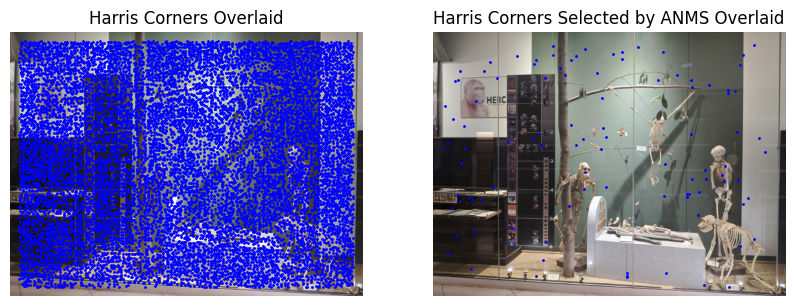

In [17]:
# The sample example for calculating squared distance between two sets of points.
def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

# Perform Adaptive Non-Maximal Suppression on detected corners.
def adaptive_non_maximal_suppression(h, coords, num_corners=100, crobust=0.9):
    strength = h[coords[0], coords[1]]
    N = len(strength)
    xi = coords.T
    xj = coords.T
    distances = dist2(xi, xj)
    min_distances = np.full(N, np.inf)
    for i in range(N):
        valid_distances = distances[i][strength[i] < crobust * strength]
        if valid_distances.size > 0:
            min_distances[i] = np.min(valid_distances)
    return coords[:, np.argsort(min_distances)[:num_corners]]

selected_coords = adaptive_non_maximal_suppression(h_response, h_corners)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(im_color)
axes[0].scatter(h_corners[1], h_corners[0], color='b', marker='o', s=1)
axes[0].set_title('Harris Corners Overlaid')
axes[0].axis('off')
axes[1].imshow(im_color)
axes[1].scatter(selected_coords[1], selected_coords[0], color='b', marker='o', s=1)
axes[1].set_title('Harris Corners Selected by ANMS Overlaid')
axes[1].axis('off')
plt.savefig('./output/anms.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Implement Feature Descriptor Extraction

&emsp;&emsp;To effectively match feature points across images, it's essential to gather more than just single pixel information. This requires the use of feature descriptors that encapsulate local details about the image, ensuring consistency across various images of the same underlying scene. To achieve this, I extracted a 40x40 window centered on each feature point, which was then downsampled into an 8x8 patch. This process included normalization and mean subtraction to enhance robustness.

&emsp;&emsp;Here is an example feature descriptor: 

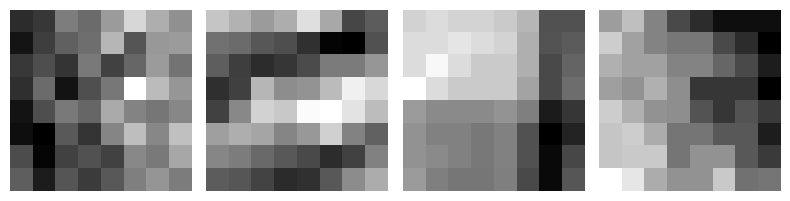

In [18]:
# Implement feature descriptor extraction.
def extract_descriptors(im, corners, patch_size=8, window_size=40):
    half_patch = patch_size // 2
    half_window = window_size // 2
    descriptors = []
    for corner in corners.T:
        y, x = corner
        y_min, y_max = max(0, y - half_window), min(im.shape[0], y + half_window)
        x_min, x_max = max(0, x - half_window), min(im.shape[1], x + half_window)
        window = im[y_min:y_max, x_min:x_max]
        patch = window[
            half_window - half_patch:half_window + half_patch,
            half_window - half_patch:half_window + half_patch
        ]
        if patch.shape == (patch_size, patch_size):
            mean = np.mean(patch)
            std_dev = np.std(patch)
            if std_dev > 0:
                normalized_patch = (patch - mean) / std_dev
            else:
                normalized_patch = patch - mean
            descriptors.append(normalized_patch.flatten())
    return np.array(descriptors)

descriptors = extract_descriptors(im_gray, selected_coords)
samples = np.random.choice(descriptors.shape[0], 4, replace=False)
fig, axes = plt.subplots(1, 4, figsize=(8, 4))
for i, idx in enumerate(samples):
    axes[i].imshow(descriptors[idx].reshape(8, 8), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig('./output/features.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Implement Feature Matching

&emsp;&emsp;To match feature descriptors, I employ ***Lowe's trick***. First, I compute the closest (1-NN) and second-closest (2-NN) matches for each feature patch. Then, the ratio between the distances of the 1-NN and 2-NN is calculated. If this ratio falls below a specified threshold, the 1-NN is considered a valid match.

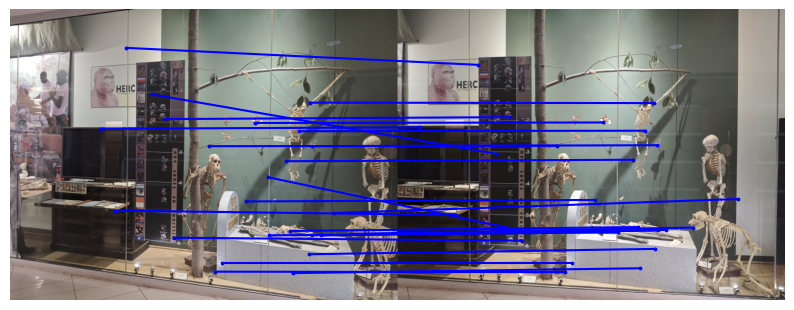

In [19]:
# Perform feature matching on two sets of descriptors.
def feature_matching(desc1, desc2, ratio_threshold=0.2):
    distances = dist2(desc1, desc2)
    matches = []
    for i in range(distances.shape[0]):
        nearest_indices = np.argsort(distances[i])
        nearest_dist = distances[i, nearest_indices[0]]
        second_nearest_dist = distances[i, nearest_indices[1]]
        if nearest_dist < ratio_threshold * second_nearest_dist:
            matches.append((i, nearest_indices[0]))
    return matches

imname1 = './media/model_left.jpg'
im1 = skio.imread(imname1)
im1_gray = rgb2gray(im1)
im1 = sk.img_as_float(im1)

imname2 = './media/model_center.jpg'
im2 = skio.imread(imname2)
im2_gray = rgb2gray(im2)
im2 = sk.img_as_float(im2)

h_response1, h_corners1 = get_harris_corners(im1_gray)
h_response2, h_corners2 = get_harris_corners(im2_gray)

coords1 = adaptive_non_maximal_suppression(h_response1, h_corners1, num_corners=1000)
coords2 = adaptive_non_maximal_suppression(h_response2, h_corners2, num_corners=1000)

descriptors1 = extract_descriptors(im1_gray, coords1)
descriptors2 = extract_descriptors(im2_gray, coords2)

matches = feature_matching(descriptors1, descriptors2, ratio_threshold=0.2)

fig, ax = plt.subplots(figsize=(10, 5))
combined_image = np.hstack((im1, im2))
ax.imshow(combined_image)
for match in matches:
    left_idx, right_idx = match
    left_coord = coords1[:, left_idx]
    right_coord = coords2[:, right_idx] + np.array([0, im1_gray.shape[1]])
    ax.plot([left_coord[1], right_coord[1]], [left_coord[0], right_coord[0]], color='b')
    ax.scatter(left_coord[1], left_coord[0], color='b', marker='o', s=3)
    ax.scatter(right_coord[1], right_coord[0], color='b', marker='o', s=3)
plt.axis('off')
plt.savefig('./output/match.jpg', dpi=300, bbox_inches='tight')
plt.show()

&emsp;&emsp;We could observe that the result is not good enough in this example since there are still some bad matches. Thus, consider Random Sample Consensus (RANSAC) for robust homography estimation.

### 4-point Random Sample Consensus (RANSAC)

&emsp;&emsp;Random Sample Consensus (RANSAC) helps minimize the influence of outliers on the resulting model. I followed the steps mentioned in course slides, here is a RANSAC loop:
1. Select four feature pairs (at random).
2. Compute homography $H$ (exact).
3. Compute *inliers* where $dist(p_{i}', Hp_{i}) < \varepsilon$.
4. Keep largest set of inliers.
5. Re-compute least-squares $H$ estimate on all of the inliers.

In [20]:
# Apply homography on given set of points.
def tansformPoints(pts, H):
    points = np.hstack((pts, np.ones((pts.shape[0], 1))))
    transformed_points = H @ points.T
    transformed_points /= transformed_points[2, :]
    return transformed_points[:2, :].T

# Perfrom RANSAC loop.
def ransac(coords1, coords2, iterations=200, threshold=0.1):
    num_points = coords1.shape[1]
    best_inliers = []
    for _ in range(iterations):
        indices = np.random.choice(num_points, 4, replace=False)
        selected_pts1 = coords1[:, indices].T
        selected_pts2 = coords2[:, indices].T

        H = computeH(selected_pts1, selected_pts2)
        transformed_pts = tansformPoints(coords1.T, H)
        distances = dist2(transformed_pts, coords2.T)
        inliers = np.where(distances < threshold ** 4)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers

    return best_inliers

&emsp;&emsp;Here is an example of applying RANSAC for automatically stitched results. We could notice that the algorithm successfully removes the poor matches.

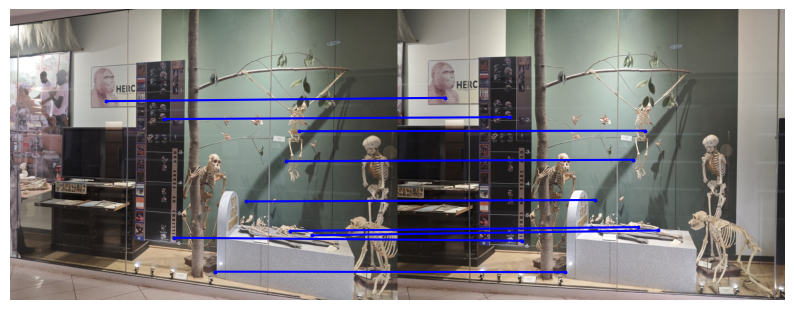

In [21]:
imname1 = './media/model_left.jpg'
im1 = skio.imread(imname1)
im1_gray = rgb2gray(im1)
im1 = sk.img_as_float(im1)

imname2 = './media/model_center.jpg'
im2 = skio.imread(imname2)
im2_gray = rgb2gray(im2)
im2 = sk.img_as_float(im2)

h_response1, h_corners1 = get_harris_corners(im1_gray)
h_response2, h_corners2 = get_harris_corners(im2_gray)

coords1 = adaptive_non_maximal_suppression(h_response1, h_corners1, num_corners=2000)
coords2 = adaptive_non_maximal_suppression(h_response2, h_corners2, num_corners=2000)

descriptors1 = extract_descriptors(im1_gray, coords1)
descriptors2 = extract_descriptors(im2_gray, coords2)

matches = feature_matching(descriptors1, descriptors2, ratio_threshold=0.2)
matched_coords1 = np.array([coords1[:, match[0]] for match in matches]).T
matched_coords2 = np.array([coords2[:, match[1]] for match in matches]).T

inliers = ransac(matched_coords1, matched_coords2, threshold=0.45)
inlier_matches = []
for match, inlier in zip(matches, inliers):
    if inlier:
        inlier_matches.append(match)
inlier_coords1 = np.array([coords1[:, match[0]] for match in inlier_matches]).T
inlier_coords2 = np.array([coords2[:, match[1]] for match in inlier_matches]).T

fig, ax = plt.subplots(figsize=(10, 5))
combined_image = np.hstack((im1, im2))
ax.imshow(combined_image)
for match in inlier_matches:
    left_idx, right_idx = match
    left_coord = coords1[:, left_idx]
    right_coord = coords2[:, right_idx] + np.array([0, im1_gray.shape[1]])
    ax.plot([left_coord[1], right_coord[1]], [left_coord[0], right_coord[0]], color='b')
    ax.scatter(left_coord[1], left_coord[0], color='b', marker='o', s=3)
    ax.scatter(right_coord[1], right_coord[0], color='b', marker='o', s=3)
plt.axis('off')
plt.savefig('./output/ransac_inliers_model.jpg', dpi=300, bbox_inches='tight')
plt.show()

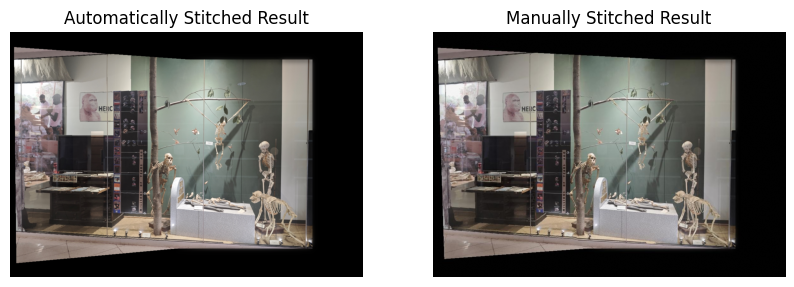

In [22]:
# Set the ratio of the borders.
ratio_h = 0.15
ratio_w = 0.2
pts1 = np.array([inlier_coords1[1], inlier_coords1[0]]).T
pts2 = np.array([inlier_coords2[1], inlier_coords2[0]]).T
im1_warp, im2_warp = warping(im1, im2, pts1, pts2, ratio_h, ratio_w)

# Set the parameters to blend the images into a mosaic.
kernel_size = (25, 25)
sigma = 15

mask = create_alpha_mask(im2_warp, im1_warp)
mask_gaussian_stack = build_gaussian_stack(mask, kernel_size, sigma, 2)  
gaussian_stack1 = build_gaussian_stack(im1_warp, kernel_size, sigma, 2)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)
gaussian_stack2 = build_gaussian_stack(im2_warp, kernel_size, sigma, 2)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)
blend_img = blend(laplacian_stack1, laplacian_stack2, mask_gaussian_stack, im1_warp.shape)
save_normalized_image(blend_img, 'ransac_model')

manual_imname = './output/manual_model.jpg'
manual_img = skio.imread(manual_imname)
manual_img = sk.img_as_float(manual_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(blend_img)
axes[0].set_title('Automatically Stitched Result')
axes[0].axis('off')
axes[1].imshow(manual_img)
axes[1].set_title('Manually Stitched Result')
axes[1].axis('off')
plt.show()

&emsp;&emsp;Comparing the manually and automatically stitched results, we could observe that the automatically one performs better on some details, such as the border of the display cabinet.

#### More Examples

&emsp;&emsp;I also considered some interesting samples I did not show you in the previous part.

##### Halloween Decoration

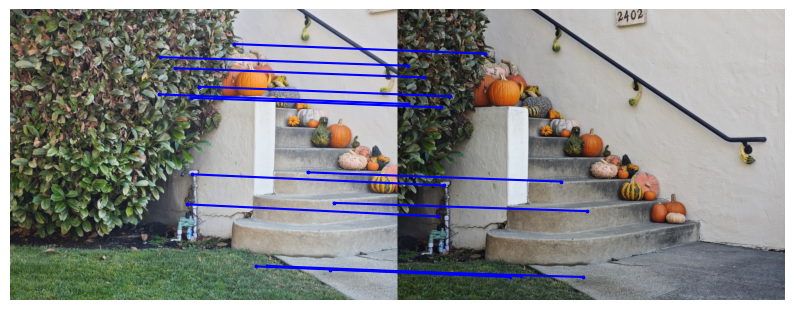

In [23]:
imname1 = './media/decoration_left.jpg'
im1 = skio.imread(imname1)
im1_gray = rgb2gray(im1)
im1 = sk.img_as_float(im1)

imname2 = './media/decoration_right.jpg'
im2 = skio.imread(imname2)
im2_gray = rgb2gray(im2)
im2 = sk.img_as_float(im2)

h_response1, h_corners1 = get_harris_corners(im1_gray)
h_response2, h_corners2 = get_harris_corners(im2_gray)

coords1 = adaptive_non_maximal_suppression(h_response1, h_corners1, num_corners=2000)
coords2 = adaptive_non_maximal_suppression(h_response2, h_corners2, num_corners=2000)

descriptors1 = extract_descriptors(im1_gray, coords1)
descriptors2 = extract_descriptors(im2_gray, coords2)

matches = feature_matching(descriptors1, descriptors2, ratio_threshold=0.2)
matched_coords1 = np.array([coords1[:, match[0]] for match in matches]).T
matched_coords2 = np.array([coords2[:, match[1]] for match in matches]).T

inliers = ransac(matched_coords1, matched_coords2, threshold=0.45)
inlier_matches = []
for match, inlier in zip(matches, inliers):
    if inlier:
        inlier_matches.append(match)
inlier_coords1 = np.array([coords1[:, match[0]] for match in inlier_matches]).T
inlier_coords2 = np.array([coords2[:, match[1]] for match in inlier_matches]).T

fig, ax = plt.subplots(figsize=(10, 5))
combined_image = np.hstack((im1, im2))
ax.imshow(combined_image)
for match in inlier_matches:
    left_idx, right_idx = match
    left_coord = coords1[:, left_idx]
    right_coord = coords2[:, right_idx] + np.array([0, im1_gray.shape[1]])
    ax.plot([left_coord[1], right_coord[1]], [left_coord[0], right_coord[0]], color='b')
    ax.scatter(left_coord[1], left_coord[0], color='b', marker='o', s=3)
    ax.scatter(right_coord[1], right_coord[0], color='b', marker='o', s=3)
plt.axis('off')
plt.savefig('./output/ransac_inliers_decoration.jpg', dpi=300, bbox_inches='tight')
plt.show()

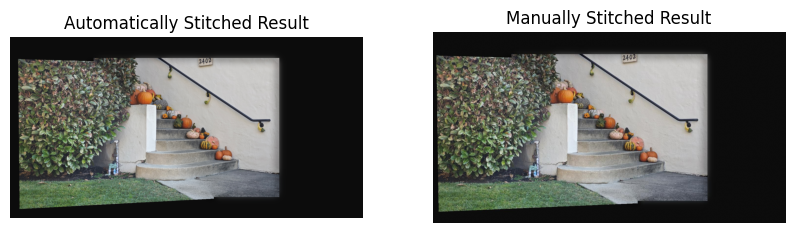

In [24]:
# Set the ratio of the borders.
ratio_h = 0.15
ratio_w = 0.45
pts1 = np.array([inlier_coords1[1], inlier_coords1[0]]).T
pts2 = np.array([inlier_coords2[1], inlier_coords2[0]]).T
im1_warp, im2_warp = warping(im1, im2, pts1, pts2, ratio_h, ratio_w)

# Set the parameters to blend the images into a mosaic.
kernel_size = (49, 49)
sigma = 36

mask = create_alpha_mask(im2_warp, im1_warp)
mask_gaussian_stack = build_gaussian_stack(mask, kernel_size, sigma, 2)  
gaussian_stack1 = build_gaussian_stack(im1_warp, kernel_size, sigma, 2)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)
gaussian_stack2 = build_gaussian_stack(im2_warp, kernel_size, sigma, 2)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)
blend_img = blend(laplacian_stack1, laplacian_stack2, mask_gaussian_stack, im1_warp.shape)
save_normalized_image(blend_img, 'ransac_decoration')

manual_imname = './output/manual_decoration.jpg'
manual_img = skio.imread(manual_imname)
manual_img = sk.img_as_float(manual_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(blend_img)
axes[0].set_title('Automatically Stitched Result')
axes[0].axis('off')
axes[1].imshow(manual_img)
axes[1].set_title('Manually Stitched Result')
axes[1].axis('off')
plt.show()

&emsp;&emsp;Both manually and automatically stitched results perform well here.

##### Forest

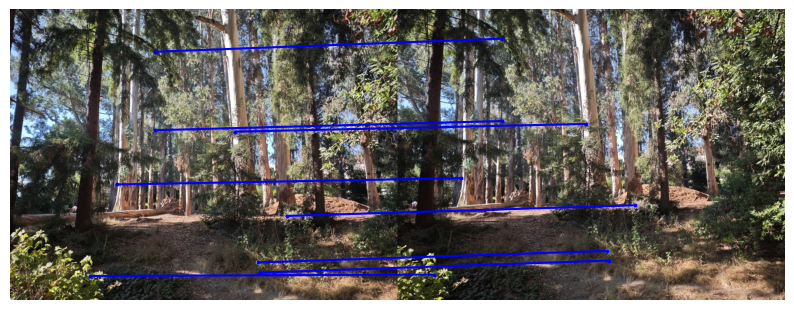

In [25]:
imname1 = './media/forest_left.jpg'
im1 = skio.imread(imname1)
im1_gray = rgb2gray(im1)
im1 = sk.img_as_float(im1)

imname2 = './media/forest_right.jpg'
im2 = skio.imread(imname2)
im2_gray = rgb2gray(im2)
im2 = sk.img_as_float(im2)

h_response1, h_corners1 = get_harris_corners(im1_gray)
h_response2, h_corners2 = get_harris_corners(im2_gray)

coords1 = adaptive_non_maximal_suppression(h_response1, h_corners1, num_corners=2000)
coords2 = adaptive_non_maximal_suppression(h_response2, h_corners2, num_corners=2000)

descriptors1 = extract_descriptors(im1_gray, coords1)
descriptors2 = extract_descriptors(im2_gray, coords2)

matches = feature_matching(descriptors1, descriptors2, ratio_threshold=0.3)
matched_coords1 = np.array([coords1[:, match[0]] for match in matches]).T
matched_coords2 = np.array([coords2[:, match[1]] for match in matches]).T

inliers = ransac(matched_coords1, matched_coords2, threshold=0.3)
inlier_matches = []
for match, inlier in zip(matches, inliers):
    if inlier:
        inlier_matches.append(match)
inlier_coords1 = np.array([coords1[:, match[0]] for match in inlier_matches]).T
inlier_coords2 = np.array([coords2[:, match[1]] for match in inlier_matches]).T

fig, ax = plt.subplots(figsize=(10, 5))
combined_image = np.hstack((im1, im2))
ax.imshow(combined_image)
for match in inlier_matches:
    left_idx, right_idx = match
    left_coord = coords1[:, left_idx]
    right_coord = coords2[:, right_idx] + np.array([0, im1_gray.shape[1]])
    ax.plot([left_coord[1], right_coord[1]], [left_coord[0], right_coord[0]], color='b')
    ax.scatter(left_coord[1], left_coord[0], color='b', marker='o', s=3)
    ax.scatter(right_coord[1], right_coord[0], color='b', marker='o', s=3)
plt.axis('off')
plt.savefig('./output/ransac_inliers_forest.jpg', dpi=300, bbox_inches='tight')
plt.show()

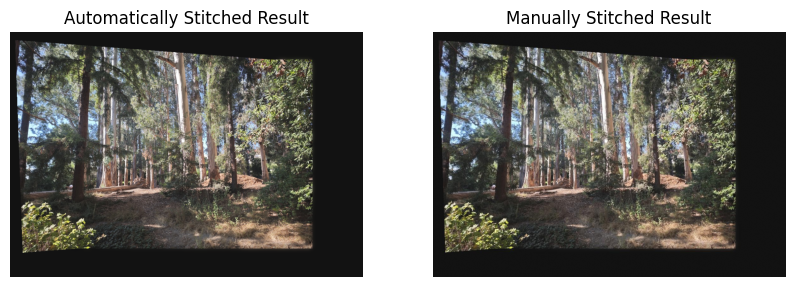

In [26]:
# Set the ratio of the borders.
ratio_h = 0.15
ratio_w = 0.2
pts1 = np.array([inlier_coords1[1], inlier_coords1[0]]).T
pts2 = np.array([inlier_coords2[1], inlier_coords2[0]]).T
im1_warp, im2_warp = warping(im1, im2, pts1, pts2, ratio_h, ratio_w)

# Set the parameters to blend the images into a mosaic.
kernel_size = (25, 25)
sigma = 15

mask = create_alpha_mask(im2_warp, im1_warp)
mask_gaussian_stack = build_gaussian_stack(mask, kernel_size, sigma, 2)  
gaussian_stack1 = build_gaussian_stack(im1_warp, kernel_size, sigma, 2)
laplacian_stack1 = build_laplacian_stack(gaussian_stack1)
gaussian_stack2 = build_gaussian_stack(im2_warp, kernel_size, sigma, 2)
laplacian_stack2 = build_laplacian_stack(gaussian_stack2)
blend_img = blend(laplacian_stack1, laplacian_stack2, mask_gaussian_stack, im1_warp.shape)
save_normalized_image(blend_img, 'ransac_forest')

manual_imname = './output/manual_forest.jpg'
manual_img = skio.imread(manual_imname)
manual_img = sk.img_as_float(manual_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(blend_img)
axes[0].set_title('Automatically Stitched Result')
axes[0].axis('off')
axes[1].imshow(manual_img)
axes[1].set_title('Manually Stitched Result')
axes[1].axis('off')
plt.show()

&emsp;&emsp;This is the most amazing example! For these images of forest, it is difficult for me to manually select the corresponding points. However, the automatical method could easily figure out them even with a tiny threshold!

## Cool Stuff I Learnt

&emsp;&emsp;My favorite parts in this project were the Image Rectification and Autostitching sections. I was thrilled to see how homography could smoothly transform images with significant distortion back into the correct alignment. Autostitching made it incredibly easy to find corresponding points between two images, which was a great experience for me. At the same time, I applied knowledge from previous projects, like the Laplacian pyramid algorithm, which made me realize that I’m systematically building my understanding of computer vision. Last but not least, I discovered just how interesting and crucial linear algebra is in these applications.